## Importing files

In [111]:
import sys
sys.path.append('I:/My Drive/suyana')
from scripts.utils.regression_functions import *

## Select directory

In [112]:
import os
path = "C:/Files/!suyana/data"
files_all = os.listdir(path)
files_ini = [f for f in files_all if f.startswith('peruvianEEZ') and f.endswith('01')]
files_ini

['peruvianEEZ_20120101_20121201',
 'peruvianEEZ_20130101_20131201',
 'peruvianEEZ_20140101_20141201',
 'peruvianEEZ_20150101_20151201',
 'peruvianEEZ_20160101_20161201',
 'peruvianEEZ_20170101_20171201',
 'peruvianEEZ_20180101_20181201',
 'peruvianEEZ_20190101_20191201',
 'peruvianEEZ_20200101_20201201',
 'peruvianEEZ_20210101_20211201',
 'peruvianEEZ_20220101_20221201',
 'peruvianEEZ_20230101_20231201',
 'peruvianEEZ_20230101_20240101',
 'peruvianEEZ_20240101_20250101']

# Create dataframe

In [113]:
df = pd.DataFrame()
for i in range(11,13):
    df_aux = pd.read_csv(
        path+'/'+files_ini[i]+'/layer-activity-data-0/'+'public-global-fishing-effort-v3.0.csv',
    )
    df = pd.concat([df,df_aux], axis = 0)
    print(df.shape)

df.columns = ['lat', 'lon', 'date', 'flag', 'gearType', 'codVessel', 'fishingHours']

(74771, 7)
(158549, 7)


In [114]:
# Convert latitudes and longitudes to decimal degrees
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

In [115]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m', errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [193]:
# Filter season dates
df_mt = df[(df['date']>='2023-10-01') & (df['date']<='2024-01-01')]
df_mt = df_mt[df_mt['flag'] == "PER"]
df_mt['date'].unique()

<DatetimeArray>
['2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [194]:
df_mt = df_mt.groupby(['lat', 'lon']).agg(
    fishingHours = ('fishingHours', 'sum'),
    n = ('fishingHours', 'count')
).reset_index()
df_mt['flagOne'] = 1

## Read the geojson file

In [118]:
import geopandas as gpd
df_geo = gpd.read_file('C:/Files/!suyana/data/peruvianEEZ_20230101_20240101/layer-reference-geometry/geometry.geojson')

Skipping field bbox: unsupported OGR type: 3


In [119]:
# Get the centroid of the polygon
df_geo.geometry.centroid

C:\Users\98acg\AppData\Local\Temp\ipykernel_19108\857082686.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_geo.geometry.centroid


0    POINT (-78.82648 -11.88536)
dtype: geometry

In [120]:
# Get the bounds of the polygon
df_geo.geometry.bounds #geometry.total_bounds for getting an array

,minx,miny,maxx,maxy
0,-84.67071,-20.20814,-70.28108,-3.39212


<Axes: >

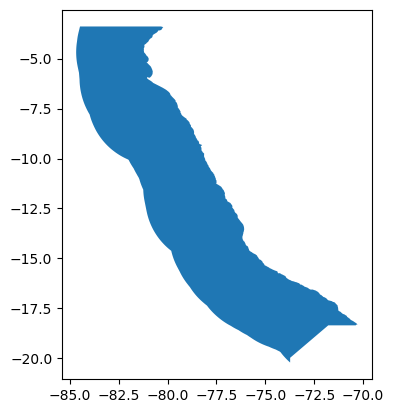

In [121]:
# Plot the area covered by the polygon
df_geo.geometry.plot()

In [67]:
from folium.plugins import HeatMap
def create_heatmap(df, zoomstart = 5):
    # Create a base map
    m = folium.Map(location=[df["lat"].mean(), df["lon"].mean()], zoom_start=zoomstart)

    # Add heatmap layer
    heat_data = [[row['lat'], row['lon'], row['fishingHours']] for index, row in df.iterrows()]
    HeatMap(heat_data).add_to(m)

    # Save or display map
    #m.save("heatmap.html")
    return m

In [154]:
df_mt['flagOne'] = 1

C:\Users\98acg\AppData\Local\Temp\ipykernel_19108\1965907041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mt['flagOne'] = 1


## Plot the distribution of hours

In [165]:
def create_static_heatmap(df, x_lims, y_lims):
    # Create a grid for heatmap
    x = df["lon"]
    y = df["lat"]
    weights = df["flagOne"]

    # Define the grid resolution
    x_edges = np.linspace(x_lims[0], x_lims[1], 100)[:,0]
    y_edges = np.linspace(y_lims[0], y_lims[1], 100)[:,0]
    print(x_edges.dtype)
    print(y_edges.dtype)

    # Compute a 2D histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=weights)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap.T, 
        xticklabels=np.round(xedges, 3), 
        yticklabels=np.round(yedges, 3), 
        cmap="YlOrRd", 
        cbar=True
    )
    plt.gca().invert_yaxis()
    plt.title("Heatmap of Fishing Hours")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [190]:
x_lims = [df_geo.geometry.bounds['minx'], df_geo.geometry.bounds['maxx']]
y_lims = [df_geo.geometry.bounds['miny'], df_geo.geometry.bounds['maxy']]

In [214]:
x = df_mt["lon"]
y = df_mt["lat"]
weights = df_mt["flagOne"]

# Define the grid resolution
x_edges = np.linspace(x_lims[0], x_lims[1], 450)[:,0]
y_edges = np.linspace(y_lims[0], y_lims[1], 450)[:,0]
print(x_edges.dtype)
print(y_edges.dtype)

# Compute a 2D histogram
heatmap, xedges, yedges = np.histogram2d(x, y, bins=[x_edges, y_edges], weights=weights)

float64
float64


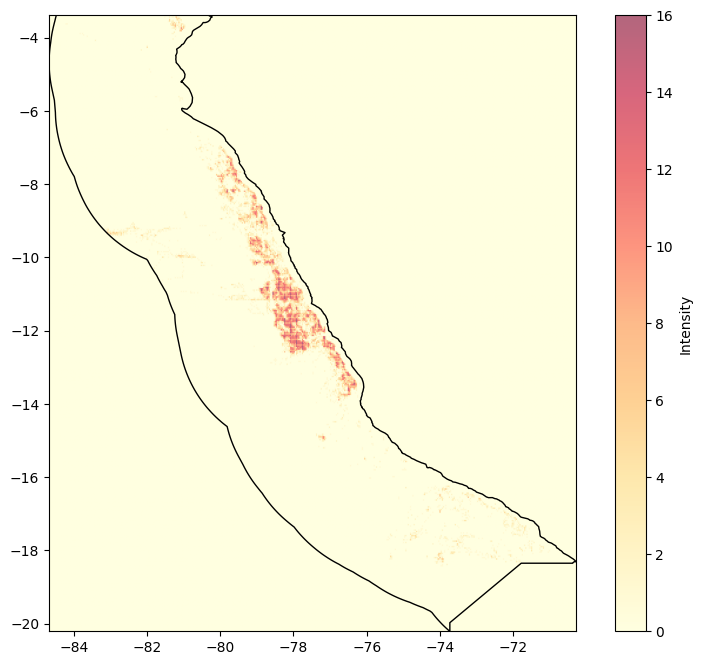

In [215]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot GeoJSON borders
df_geo.boundary.plot(ax=ax, color="black", linewidth=1)

# Overlay heatmap
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(
    heatmap.T, 
    extent=extent, 
    origin="lower", 
    cmap="YlOrRd", 
    alpha=0.6,  # Transparency
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Intensity")

float64
float64


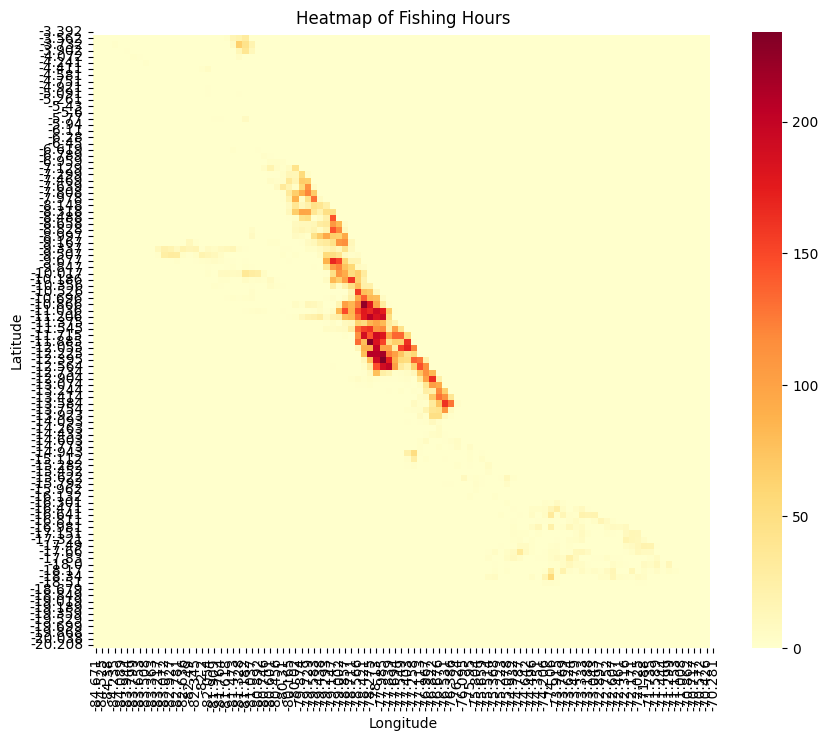

In [205]:
create_static_heatmap(df_mt, x_lims, y_lims)

In [143]:
map1 = create_heatmap(df_mt, 4)
map1

In [70]:
map2 = create_heatmap(df_mt[df_mt['fishingHours']>1.5], 4)
map2

In [66]:
df_mt[df_mt['fishingHours']<0.01]

,lat,lon,date,flag,gearType,codVessel,fishingHours,year,month
47685,-7.75,-79.54,2023-11-01,PER,fishing,1,0.0,2023,11
73233,-13.82,-76.25,2023-11-01,NaN,pole_and_line,1,0.0,2023,11
3532,-7.41,-79.68,2023-12-01,PER,fishing,1,0.0,2023,12
19226,-13.83,-76.56,2023-12-01,PER,other_purse_seines,1,0.0,2023,12
21705,-13.82,-76.25,2023-11-01,NaN,pole_and_line,1,0.0,2023,11
56137,-7.75,-79.54,2023-11-01,PER,fishing,1,0.0,2023,11
